Part 1 consists of loading in the data given and calculting the reconstructed mass based on the four properties of the particles observed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#importing data
data = np.loadtxt('atlas_z_to_ll.csv', delimiter =',', skiprows=1)
pt1 = data[:,0] #GeV
pt2 = data[:,1] #GeV
eta1 = data[:,2] #rad
eta2 = data[:,3] #rad
phi1 = data[:,4] #rad
phi2 = data[:,5] #rad
E1 = data[:,6] #GeV
E2 = data[:,7] #GeV

#mass caLculation
#Equations 1 addapted
def px(pt,phi):
    px = pt*np.cos(phi)
    return px

def py(pt,phi):
    py = pt*np.sin(phi)
    return py

def pz(pt,eta):
    pz = pt*np.sinh(eta)
    return pz

#Equation 2
def M(E, px,py,pz):
    M = (E**2 - (px**2 + py**2 + pz**2))**0.5
    return M 

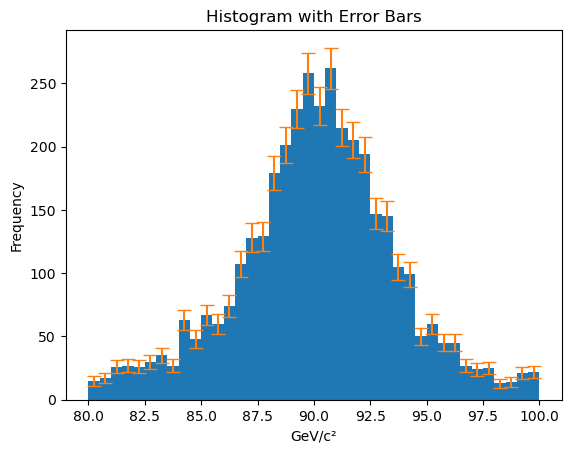

In [2]:
#Calculating the transverse momenta for both particles
px1 = px(pt1,phi1)
py1 = py(pt1,phi1)
pz1 = pz(pt1,eta1)
px2 = px(pt2,phi2)
py2 = py(pt2,phi2)
pz2 = pz(pt2,eta2)

#Combining all the transverse momenta and energy within one variable
p1 = np.array([E1,px1,py1,pz1])
p2 = np.array([E2,px2,py2,pz2])
ptot = p1+p2

#Calculates the reconstructed mass
mass = M(ptot[0], ptot[1], ptot[2],ptot[3]) #GeV

#Requested bins
bins = np.linspace(80,100,41)

# Calculate histogram values and bin edges
hist, bin_edges = np.histogram(mass, bins=bins)

# Calculate bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate error bars (e.g., standard deviation of the counts in each bin)
error = np.sqrt(hist)

# Plot the histogram with error bars
fig,ax=plt.subplots(1,1)
ax.hist(mass, bins=bins)
ax.errorbar(bin_centers, hist, yerr=error, linestyle='none', capsize=5)
ax.set_xlabel("GeV")
ax.set_ylabel("Frequency")
ax.set_title("Histogram with Error Bars")
plt.show()

Part 2 consists of constructing best fit curve for the data set and making a chisq analysis to determine if the functions fits the data.

Fit stats
Best‐fit m0       = 90.34081 ± 0.09352 GeV
Chi‑square        = 9.99
Degrees of freedom= 10
Reduced chi‑sq    = 1.00
p‑value           = 0.442


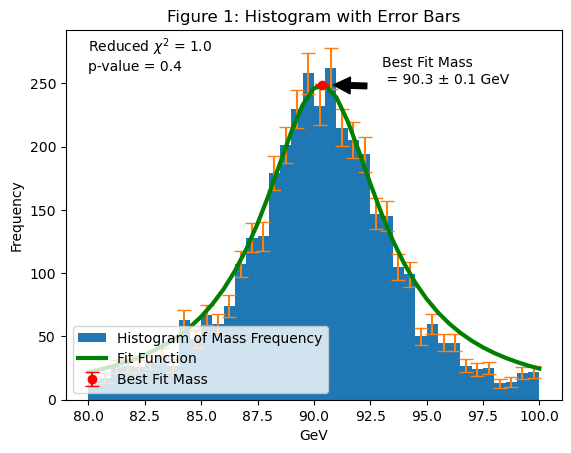

In [3]:
#Part 2
c = 3*10e8
mZ0 = 91.1880 #Gev 
sigma_mZ0 = 0.0020 #Gev 

#Distribution of decayse equation for a Breit-Wigner Peak
def D(m, m0, L):
    term1 = 1/np.pi
    term2 = (L/2)/((m-m0)**2 + (L/2)**2)
    return term1*term2

#Requested normalization term
norm = 5000/2

#function used to fit the data using the normalization term
def fit_func(m, m0, L):
    return norm * D(m, m0, L)

#masking around bin centers
mask = (bin_centers > 87) & (bin_centers < 93)
#m is within the mask

#data points withing the mask
m = bin_centers[mask]
y_fit = hist[mask]
yerr = np.sqrt(y_fit)

from scipy.optimize import curve_fit
from scipy import stats

#Calculating best fit parameters and their associated error
p0 = [91, 3.0]
params, covar = curve_fit(fit_func, m, y_fit, sigma=yerr, p0=p0, absolute_sigma=True)
m0_fit = params[0]
L_fit = params[1]
err = np.sqrt(np.diag(covar))

#fit function for calculating chisq
fit = fit_func(bins, m0_fit, L_fit)
y_model = fit_func(m,m0_fit, L_fit)

#chisq, dof, reduced chisq, P
chisq = np.sum( (y_fit - y_model)**2 / yerr**2 )
dof= len(y_model) - 2
chisq_reduced = chisq/dof
P_val = stats.chi2.sf(chisq, dof)

print("Fit stats")
print(f"Best‐fit m0       = {m0_fit:.5f} ± {err[0]:.5f} GeV")
print(f"Chi‑square        = {chisq:.2f}")
print(f"Degrees of freedom= {dof}")
print(f"Reduced chi‑sq    = {chisq_reduced:.2f}")
print(f"p‑value           = {P_val:.3f}")

#Plotting fit curve and additional information
fig,ax=plt.subplots(1,1)
ax.hist(mass, bins=bins, label='Histogram of Mass Frequency')
ax.errorbar(bin_centers, hist, yerr=error, linestyle='none', capsize=5)
ax.plot(bins, fit, linewidth=3, color='green', label='Fit Function')
ax.errorbar(m0_fit, fit_func(m0_fit, m0_fit, L_fit), yerr=err[0], ls="None", marker="o", c="red", capsize=5, label="Best Fit Mass")
ax.set_xlabel("GeV")
ax.set_ylabel("Frequency")
ax.annotate(f"Best Fit Mass\n = {m0_fit:.1f} ± {err[0]:.1f} GeV", xy=(m0_fit, fit_func(m0_fit, m0_fit, L_fit)), xytext = (93.0 ,250), arrowprops=dict(facecolor='black', shrink=0.2))
ax.set_title("Figure 1: Histogram with Error Bars")
ax.text(80, 275, rf"Reduced $\chi^2$ = {chisq_reduced:.1f}")
ax.text(80, 260, f"p-value = {P_val:.1f}")
ax.legend(loc="lower left")
plt.tight_layout
plt.show()


Part 3 is a 2D contour scan for analysing how the two parameters for gamma and reconstructed mass affect one another and the best fit for both parameters within the given data set.

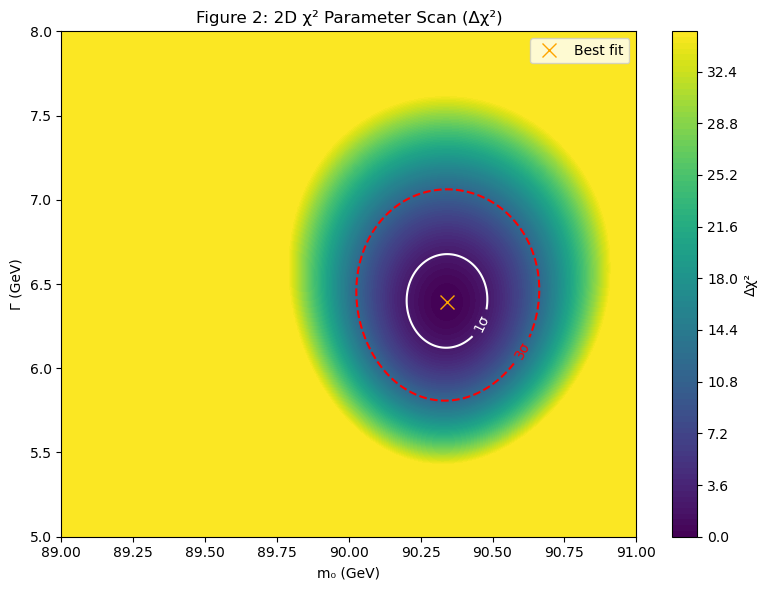

In [4]:
# Part 3 

#Binning within requested ranges
n_bins = 300
chi_map = np.zeros((n_bins, n_bins))
m0 = np.linspace(89,91,n_bins)
L = np.linspace(5,8,n_bins)

#double for loop as showcased in previous lectures
for i, Lv in enumerate(L):
    for j, mv in enumerate(m0):
        pred = fit_func(m, mv, Lv)
        chi_map[i, j] = np.sum(((y_fit-pred)/yerr)**2)

#minimum chisq for finding delta chisq
min_chi2 = chi_map.min()
dchi2   = np.clip(chi_map-min_chi2, 0, 35)

from scipy.stats import chi2

# 1σ & 3σ for 2 params
levels = [chi2.ppf(0.683,2), chi2.ppf(0.997,2)]

# contour plot with requested confidence levels
fig, ax = plt.subplots(figsize=(8,6))
cf = ax.contourf(m0, L, dchi2, levels=100, cmap='viridis')
fig.colorbar(cf, label=r'Δχ²')
cs = ax.contour(m0, L, dchi2, levels=levels, colors=['white','red'], linestyles=['-','--'])
ax.clabel(cs, fmt={levels[0]:'1σ', levels[1]:'3σ'})
ax.plot(m0_fit, L_fit, 'x', ms=10, color='orange', label='Best fit')
ax.set_xlabel('m₀ (GeV)'); 
ax.set_ylabel('Γ (GeV)')
ax.set_title('Figure 2: 2D χ² Parameter Scan (Δχ²)')
ax.legend(); 
plt.tight_layout()
plt.show()
